In [16]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

NX = 100
NY = 100
w_i = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])# weights, note that the last four (edges) 
# are the interpolation points with the highest velocity; weights influence probability density
c_ij = np.array([[0, 1,  0, -1, 0, 1, -1, -1, 1], [0, 0, 1, 0, -1, 1, 1, -1, -1]])# velocities x and y component

In [17]:
u_anm = np.zeros((2,NX,NY))

In [18]:
y = np.arange(0, NY)
L = NY
v = np.sin(2*np.pi/L*y)
# wave along the y-direction at one x

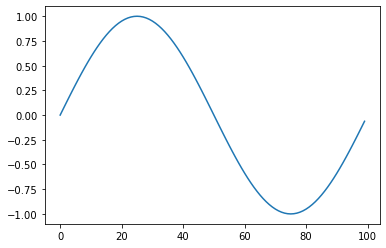

In [19]:
plt.plot(v)

In [20]:
# set initial density
rho = np.zeros((NX, NY))
rho[:,:] = 1 + 0.5 * np.sin(2*np.pi*y/L)
u = np.zeros((2,NX, NY))

array([[1.        , 1.03139526, 1.06266662, ..., 0.90630934, 0.93733338,
        0.96860474],
       [1.        , 1.03139526, 1.06266662, ..., 0.90630934, 0.93733338,
        0.96860474],
       [1.        , 1.03139526, 1.06266662, ..., 0.90630934, 0.93733338,
        0.96860474],
       ...,
       [1.        , 1.03139526, 1.06266662, ..., 0.90630934, 0.93733338,
        0.96860474],
       [1.        , 1.03139526, 1.06266662, ..., 0.90630934, 0.93733338,
        0.96860474],
       [1.        , 1.03139526, 1.06266662, ..., 0.90630934, 0.93733338,
        0.96860474]])

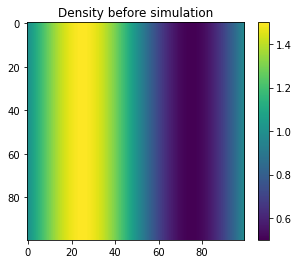

In [21]:
fig, ax = plt.subplots()
im = ax.imshow(rho)
plt.title("Density before simulation")
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.show()


In [22]:
# simulate the streaming
f_inm = np.einsum('i,jk -> ijk', w_i, np.ones((NX, NY)))# product of two arrays

def dens_lattice_point(f_vxy):
    return np.einsum('vxy -> xy', f_vxy)

def vel_field_lattice_point(f_vxy):
    return 1/dens_lattice_point(f_vxy) * np.einsum('ij, ixy -> jxy', c_ij.T, f_vxy)

def stream(f_ijk):
    # define a velocity vector containing all shifting directions
    c_ij = [[0, 0],[0, 1],[-1, 0],[0, -1], [1, 0], [-1, 1], [-1, -1], [1, -1], [1, 1]]
    for p in range(1,9):
        f_ijk[p] = np.roll(f_ijk[p], shift=c_ij[p], axis=(0,1))
    return f_ijk

f_eq_vxy = np.zeros((9, NX, NY)) # reshape?

def equi_dist(rho, av_vel):
    u_abs = np.einsum('inm, inm -> nm',abs(av_vel),abs(av_vel))
    for j in range(9):
        scal = np.einsum('j, jnm -> nm', c_ij.T[j], av_vel)
        f_eq_vxy[j] = w_i[j] * rho *(1 + 3*scal + 9/2*scal**2- 3/2 * u_abs)
    return f_eq_vxy

def comp_new_dist(f_vxy, f_eq, omega = 1):
    f_vxy += omega * (f_eq - f_vxy)
    # omega describes the impact of the relaxation
    return f_vxy

Simulating: 100%|██████████████████████████| 3000/3000 [00:07<00:00, 390.80it/s]


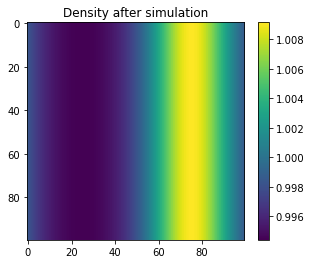

In [23]:
f_inm_eq = equi_dist(rho, u)
f_inm = f_inm_eq

for t in tqdm(range(3000), "Simulating"):
    
    f_inm = comp_new_dist(f_inm, f_inm_eq, omega = 1)

    f_inm = stream(f_inm)
    rho = dens_lattice_point(f_inm)
    
    u = vel_field_lattice_point(f_inm)
    f_inm_eq = equi_dist(rho, u)

fig, ax = plt.subplots()
im = ax.imshow(rho)
plt.title("Density after simulation")
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.savefig("decay_plot.png")
plt.show()
# density flatens with the streaming

In [40]:
# shear wave simulation initial conditions
X, Y = np.meshgrid(np.arange(NX),np.arange(NY))
rho[:,:] = 1
u[0] = 0.1 * np.sin(2*np.pi/L * Y)
u[1] = np.zeros((NX, NY))
u = np.stack((u[0], u[1]), axis=0)

Simulating: 100%|██████████████████████████| 5000/5000 [00:10<00:00, 458.92it/s]


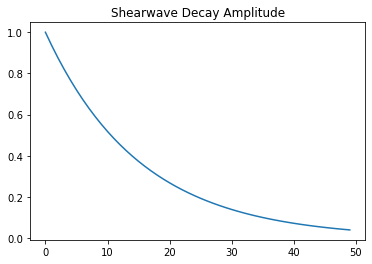

In [41]:
f_inm_eq = equi_dist(rho, u)
f_inm = f_inm_eq

amp = []

for t in tqdm(range(5000), "Simulating"):
    
    f_inm = comp_new_dist(f_inm, f_inm_eq, omega = 1)

    f_inm = stream(f_inm)
    rho = dens_lattice_point(f_inm)
    
    u = vel_field_lattice_point(f_inm)
    f_inm_eq = equi_dist(rho, u)
    
    if t%100 == 0:
        u_cut = u[:,:,30]
        amp.append((np.max(u_cut[0])) /0.1)

plt.plot(np.arange(len(amp)), amp)
plt.title("Shearwave Decay Amplitude")
plt.savefig("decay_plot.png")
plt.show()

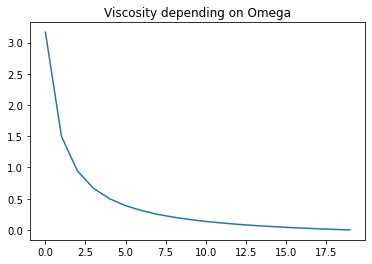

In [43]:
# compute theoretical viscosity
omega = 0.0
viscosity = 0
vis_plot = []
for i in range(20):
    omega += 0.1
    viscosity = 1/3 * (1/omega - 1/2)
    vis_plot.append(viscosity)
plt.plot(np.arange(len(vis_plot)), vis_plot)
plt.title("Viscosity depending on Omega")
plt.savefig("viscosity_plot.png")
plt.show()

In [47]:
# measure viscosity for different omega
# shear wave simulation initial conditions
X, Y = np.meshgrid(np.arange(NX),np.arange(NY))
rho[:,:] = 1
u[0] = 0.1 * np.sin(2*np.pi/L * Y)
u[1] = np.zeros((NX, NY))
u = np.stack((u[0], u[1]), axis=0)

f_inm_eq = equi_dist(rho, u)
f_inm = f_inm_eq

amp = []

for t in tqdm(range(1000), "Simulating"):
    
    f_inm = comp_new_dist(f_inm, f_inm_eq, omega = 1.9)

    f_inm = stream(f_inm)
    rho = dens_lattice_point(f_inm)
    
    u = vel_field_lattice_point(f_inm)
    f_inm_eq = equi_dist(rho, u)
u_cut = u[:,:,30]
np.max(u_cut[0])

Simulating: 100%|██████████████████████████| 1000/1000 [00:02<00:00, 448.19it/s]


0.05178997399159445

In [62]:
# second experiment
rho[:,:] = 1
# set x component of u to sinus wave
u[0] = 0.01*np.sin(np.pi/NY*Y)

In [64]:
#for t in range(10):
    #f_eq = equi_dist(rho, u)
f_inm = stream(f_inm)
f_inm = comp_new_dist(f_inm, f_eq, omega = 1)
rho = dens_lattice_point(f_inm)
u = vel_field_lattice_point(f_inm)

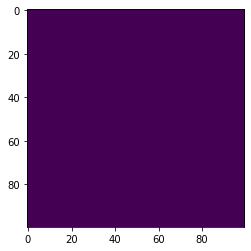

In [65]:
plt.imshow(u[0])

In [67]:
# viscosity ny = 1/3(1/w - 1/2); w <= 1,7

(2, 100, 100)